# Plotting Decision Boundaries

This supplementary notebook explains the logic behind the rather complicated-looking 'plot_decision_boundary' function.

### When is it used

Plotting decision boundaries is a useful visualization technique for the following tasks:

- Classification: when classes are labelled (supervised learning), helps visualize where the classifier predicts the boundaries between the class

- Clustering: when no classes are labelled (unsupervised learning), helps visualize where one possible cluster begins and another cluster ends.

## Outline
First we'll cover how the plot works in steps.

Then we'll walk through an example dataset for each step.

### How the plot works

1. If the feature ranges are very different, we apply StandardScaler to scale the features. Otherwise, the boundary plot can take a long time to process, or the plot will look skewed.

2. If the features are multi-dimensional, we first reduce the dimension of the features to 2D.  This is done using PCA (commonly) or t-SNE (if text-based and therefore sparse).
  - What about 3D? Same technique applies, except the matplotlib axes are in 3D.
  - What about 1D? Well, visualizing the boundary in 1D involves plotting a vertical line.  It's not as intuitive to visualize than 2D, and won't work for clustering, where there are no y-values (no classes).

The rest of the discussion assumes we are doing 2D plots.

3. For each feature (X_2d[:, 0] and X_2d[:, 1]), find the max and min values to create a bounding box: x_min, x_max, y_min, y_max
  - x_min, x_max are the left and right limits of the plot
  - y_min, y_max are the lower and upper limits of the plot


4. Now comes the most complex part. Ideally, for boundaries we also want to colour the classes or clusters according to the class id or cluster id. Something like countries on a map. 

The way to accomplish this is to:
 a. Create a 2D matrix with the following specifications:
  - np.arange(x_min, x_min, 0.05) on the horizontal axis
  - np.arange(y_min, y_max, 0.05) on the vertical axis
  - Every value in that 2D matrix is 0.05 step apart (units don't matter as much here, because we will be plotting PCA)
  - We use [np.meshgrid](https://docs.scipy.org/doc/numpy/reference/generated/numpy.meshgrid.html), to generate the matrix.
    - Depending on the data (i.e. X_2d), you may need to adjust the step size larger (if the data is spaced out), or smaller (if the data is close together).
    - Note that a smaller step size can run very slowly. 

  b. For each value in the 2D matrix, run predict() using either the classifier or the clustering algorithm.
 
  c. Plot the predicted values *as an image*, using the predicted values as the colours. 
    - This is done using [imshow](https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.imshow.html).
    - In the "empty" spaces between the 0.05 steps, the colours are filled in using interpolation. This creates the solid colours characteristic of a boundary plot.


5. Last step of the boundary plot is to scatter plot the values:
  - The actual samples.
  - For clustering using k-means the centroids are also plotted.

### Example dataset

We'll use the COE dataset from the clustering lecture.

It can be found at: https://data.gov.sg/dataset/coe-bidding-results

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
df = pd.read_csv('D:/tmp/coe-bidding-results/coe-results.csv', # fix to your path
                 usecols=['quota', 'premium'])
df.describe()

,quota,premium
count,985.000000,985.000000
mean,551.541117,46445.775635
std,452.628678,26065.702205
min,140.000000,852.000000
25%,294.000000,31006.000000
50%,373.000000,50502.000000
75%,559.000000,65001.000000
max,2272.000000,97889.000000


1. Scale the features

In [20]:
from sklearn.preprocessing import StandardScaler

X = df.loc[:, ['quota', 'premium']]

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

2. PCA is skipped because X (and therefore X_scaled) is already in 2D

In [21]:
print(X_scaled.shape)

(985, 2)


3. Find the bounding box of our 2D plot

In [22]:
# left and right plot limits
# (x_ just denotes horizontal axis on the plot, unrelated to X)

x_min, x_max = X_scaled[:, 0].min() - 1, X_scaled[:, 0].max() + 1

print('plot left limit: %.3f, plot right limit: %.3f' %(x_min, x_max))

plot left limit: -1.910, plot right limit: 4.803


In [23]:
# upper and lower plot limits
# (y_ just denotes vertical axis on the plot, unrelated to our labels)

y_min, y_max = X_scaled[:, 1].min() - 1, X_scaled[:, 1].max() + 1

print('plot lower limit: %.3f, plot upper limit: %.3f' %(y_min, y_max))

plot lower limit: -2.750, plot upper limit: 2.975


4a. Create a 2D matrix with the following specifications:
 - np.arange(x_min, x_min, 0.25) on the horizontal axis
 - np.arange(y_min, y_max, 0.25) on the vertical axis
 - Every value in that 2D matrix is 0.25 step apart (units don't matter as much here, because we will be plotting PCA)
 - We use [np.meshgrid](https://docs.scipy.org/doc/numpy/reference/generated/numpy.meshgrid.html), to generate the matrix.
 - Depending on the data (i.e. X_2d), you may need to adjust the step size larger (if the data is spaced out), or smaller (if the data is close together).
 - Note that a smaller step size can run very slowly. 

In [85]:
step = .05

xx, yy = np.meshgrid(np.arange(x_min, x_max, step),
                     np.arange(y_min, y_max, step))

# a. flatten xx using ravel into [xx0, xx1, .., xxN]
# b. flatten yy using ravel into [yy0, yy1, .., yyN]
# c. column stack into a 2-D array
#    (turn xx, yy into column vectors and then stack column-wise)
#
#   [[xx0, yy0],
#    [xx1, yy1],
#    ..
#    [xxN, yyN]]
#

mesh = np.column_stack((xx.ravel(), yy.ravel()))
mesh

# this also works, but easy to forget what it does
# mesh = np.c_[xx.ravel(), yy.ravel()]

array([[-1.90968646, -2.75007514],
       [-1.85968646, -2.75007514],
       [-1.80968646, -2.75007514],
       ...,
       [ 4.69031354,  2.94992486],
       [ 4.74031354,  2.94992486],
       [ 4.79031354,  2.94992486]])

In [63]:
mesh.shape

(15525, 2)

4b. For each value in the 2D matrix, run predict() using either the classifier or the clustering algorithm.

In [79]:
from sklearn.cluster import KMeans

# first, fit on our dataset (note: not the mesh)
kmeans = KMeans(n_clusters=5)
kmeans.fit(X_scaled)

# next, predict on our mesh
clusters = kmeans.predict(mesh)
clusters

array([3, 3, 3, ..., 2, 2, 2])

4c. Plot the predicted values *as an image*, using the predicted values as the colours. 
 - This is done using [imshow](https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.imshow.html).
 - In the "empty" spaces between the 0.05 steps, the colours are filled in using interpolation. This creates the solid colours characteristic of a boundary plot.

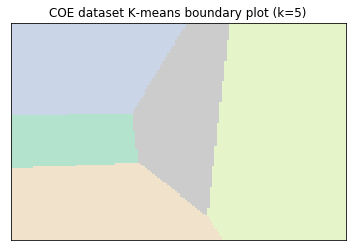

In [82]:
fig, ax = plt.subplots()

# convert to 2D array for image
clusters_image = clusters.reshape(xx.shape)

ax.imshow(clusters_image, interpolation='nearest',
          extent=(xx.min(), xx.max(), yy.min(), yy.max()),
          cmap=plt.cm.Pastel2,
          aspect='auto', # image aspect ratio
          origin='lower') # origin of image is bottom left

ax.set(title='COE dataset K-means boundary plot (k=%d)' % kmeans.n_clusters,
       xlim=(x_min, x_max), ylim=(y_min, y_max),
       xticks=(), yticks=())

plt.show()

5. Last step of the boundary plot is to scatter plot the values:
  - The actual samples.
  - For clustering using k-means the centroids are also plotted.

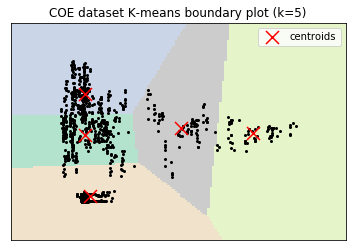

In [83]:
fig, ax = plt.subplots()

ax.imshow(clusters_image, interpolation='nearest',
          extent=(xx.min(), xx.max(), yy.min(), yy.max()),
          cmap=plt.cm.Pastel2,
          aspect='auto',
          origin='lower')

ax.plot(X_scaled[:, 0], X_scaled[:, 1], 'k.', markersize=4)

centroids = kmeans.cluster_centers_

ax.scatter(centroids[:, 0], centroids[:, 1],
           marker='x', s=169, linewidths=3,
           color='red', zorder=10, label='centroids')

ax.set(title='COE dataset K-means boundary plot (k=%d)' % kmeans.n_clusters,
       xlim=(x_min, x_max), ylim=(y_min, y_max),
       xticks=(), yticks=())
ax.legend()
plt.show()

## Helper Function

This is the helper function that combines steps 3, 4, and 5. The variables are named somewhat differently, but the steps are the same.

In [86]:
import numpy as np

def plot_decision_boundaries(ax, title, kmeans_model, data):
    """Plots the decision boundaries for a fitted k-means model
    Args:
        ax: subplot axis
        title: subplot title
        kmeans_model: a fitted sklearn.cluster.KMeans model
        data: 2-dimensional input data to cluster and plot
 
    Based on: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html
    """
    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh using the trained model.
    Z = kmeans_model.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)

    ax.imshow(Z, interpolation='nearest',
              extent=(xx.min(), xx.max(), yy.min(), yy.max()),
              cmap=plt.cm.Pastel2,
              aspect='auto', origin='lower')

    ax.plot(data[:, 0], data[:, 1], 'k.', markersize=4)

    # Plot the centroids as a red X
    centroids = kmeans.cluster_centers_

    ax.scatter(centroids[:, 0], centroids[:, 1],
               marker='x', s=169, linewidths=3,
               color='red', zorder=10, label='centroids')
    ax.set(title=title,
           xlim=(x_min, x_max), ylim=(y_min, y_max),
           xticks=(), yticks=())
    ax.legend()